# **Predictive Analytics for Optimizing "Time-to-Export" Lead Times in Kenya’s Horticultural Supply Chain**

This project develops a machine learning–driven analytics pipeline to predict time-to-export lead times for Kenya’s horticultural exports. Time-to-export is defined as the total elapsed time from packhouse or farm handover to final departure via Jomo Kenyatta International Airport (JKIA) or Mombasa Port.

The solution targets highly perishable exports including cut flowers, fruits, and vegetables, where delays directly translate into spoilage, missed market windows, and revenue losses.

By replacing experience-based estimates with data-driven predictions, the project aims to improve planning, reduce post-harvest losses, and strengthen supply chain resilience in one of Kenya’s most important foreign-exchange-earning sectors.

# Main Objective
To develop a robust, accurate machine learning regression model that predicts total export lead time (in hours or days) for Kenyan horticultural shipments, enabling proactive planning and risk mitigation.

## Specific Objectives
- Load and inspect the 5,000-record consignment dataset
- Perform initial data exploration and quality checks
- Conduct descriptive analytics: overall delay rate, processing times, and key distributions
- Identify delay patterns by origin/destination, commodity, time/day, and ports
- Uncover early red-flag signals (document completeness, amendments, congestion)
- Build and evaluate a baseline Random Forest Classifier for delay prediction
- Visualize insights and model performance (classification report, confusion matrix)

## Stakeholders
- International freight forwarders
- Customs & port operators
- Exporters of perishable commodities
- Supply chain analytics teams

## Project Scope
- Loading and basic exploration of the dataset
- Data structure & quality check (df.info(), df.describe())
- Statistical summary of numerical features
- Training a baseline Random Forest Classifier to predict delayed_flag
- Automatic categorical & numerical preprocessing via Pipeline
- Model evaluation via classification report and confusion matrix
- Visualization of precision/recall/F1-score and confusion matrix heatmap
- Feature engineering from nested columns (documents, events)
- Regression modeling
- Hyperparameter tuning or cross-validation
- Additional algorithms (XGBoost, etc.)
- Model deployment or dashboard


In [1]:
# Import core data science and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import modeling and evaluation tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)


# **DATA UNDERSTANDING**
Load the file and evaluate how the data is structured in order to decide the analysis and modelling path for the project.

In [2]:

# Load dataset
# JSON Lines format represents individual consignments
df = pd.read_json("tlip_like_consignments_5000.jsonl", lines=True)

# Inspect structure and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   consignment_id          5000 non-null   object        
 1   created_at              5000 non-null   datetime64[ns]
 2   origin_country          5000 non-null   object        
 3   destination_country     5000 non-null   object        
 4   origin_port             5000 non-null   object        
 5   destination_port        5000 non-null   object        
 6   shipment_mode           5000 non-null   object        
 7   commodity               5000 non-null   object        
 8   hs_code                 5000 non-null   int64         
 9   gross_weight_kg         5000 non-null   float64       
 10  declared_value_usd      5000 non-null   float64       
 11  exporter_profile        5000 non-null   object        
 12  doc_completeness_score  5000 non-null   float64 

In [3]:
# Preview data entries
df.head(10)

,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events
0,TLIP-SYN-000001,2025-02-21 09:38:50,RW,ES,Kigali,Madrid,AIR,Mangoes,804,7636.85,...,42.65,37.66,48,80.32,1,4.32,802-78096246,,"[{'consignment_id': 'TLIP-SYN-000001', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000001', 'event'..."
1,TLIP-SYN-000002,2025-01-13 05:46:46,RW,IT,Kigali,Genoa,AIR,Fresh Beans,708,21069.24,...,50.00,25.19,48,75.19,0,0.00,148-27192561,,"[{'consignment_id': 'TLIP-SYN-000002', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000002', 'event'..."
2,TLIP-SYN-000003,2025-09-19 04:40:34,TZ,NL,Dar es Salaam,Rotterdam,AIR,Cut Flowers,603,15769.06,...,31.82,29.51,48,61.34,0,0.00,252-21633769,,"[{'consignment_id': 'TLIP-SYN-000003', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000003', 'event'..."
3,TLIP-SYN-000004,2025-12-04 07:26:32,RW,DE,Kigali,Frankfurt,AIR,Cut Flowers,603,21497.58,...,46.19,38.15,48,84.34,1,8.34,901-77635129,,"[{'consignment_id': 'TLIP-SYN-000004', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000004', 'event'..."
4,TLIP-SYN-000005,2025-05-08 16:09:41,ET,FR,Addis Ababa-ADD,Paris-CDG,SEA,Pineapples,804,21298.46,...,58.94,85.32,96,144.26,1,20.26,BL823732870,XCDZ0728567,"[{'consignment_id': 'TLIP-SYN-000005', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000005', 'event'..."
5,TLIP-SYN-000006,2025-01-19 02:40:33,UG,ES,Entebbe,Madrid,AIR,Mangoes,804,14059.91,...,35.13,6.00,48,41.13,0,0.00,926-12315968,,"[{'consignment_id': 'TLIP-SYN-000006', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000006', 'event'..."
6,TLIP-SYN-000007,2025-06-14 20:09:23,KE,IT,Mombasa,Genoa,AIR,Fresh Beans,708,9461.68,...,45.04,52.38,48,97.42,1,21.42,991-94983420,,"[{'consignment_id': 'TLIP-SYN-000007', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000007', 'event'..."
7,TLIP-SYN-000008,2025-11-01 02:35:57,KE,UK,Mombasa,London-Heathrow,AIR,Avocados,804,24028.28,...,33.77,40.51,60,74.28,0,0.00,107-57923931,,"[{'consignment_id': 'TLIP-SYN-000008', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000008', 'event'..."
8,TLIP-SYN-000009,2025-04-11 22:12:47,TZ,DE,Kilimanjaro-JRO,Frankfurt,AIR,Fresh Herbs,1211,20814.02,...,22.26,24.16,48,46.41,0,0.00,206-36291565,,"[{'consignment_id': 'TLIP-SYN-000009', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000009', 'event'..."
9,TLIP-SYN-000010,2025-07-11 02:10:47,RW,DE,Kigali,Hamburg,SEA,Vegetables Mix,709,11674.31,...,54.60,73.51,96,128.11,1,4.11,BL473371905,WPAP1898399,"[{'consignment_id': 'TLIP-SYN-000010', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000010', 'event'..."


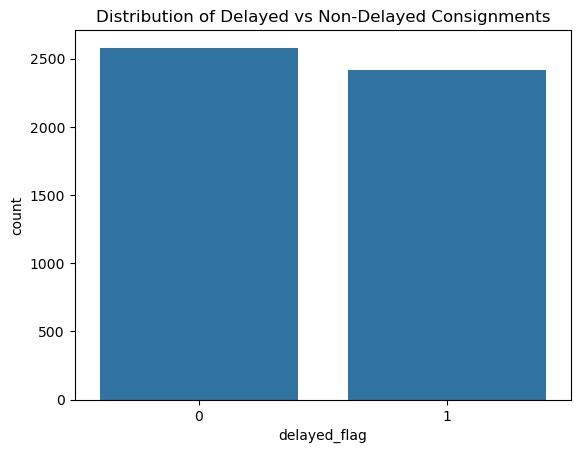

In [4]:

# Target variable distribution
# Check for class imbalance
sns.countplot(x="delayed_flag", data=df)
plt.title("Distribution of Delayed vs Non-Delayed Consignments")
plt.show()

# **EXPLORATORY DATA ANALYSIS (EDA)**

**EDA Objectives**
*   Understand feature distributions
*   Identify potential drivers of delay
*   Validate assumptions before modeling





In [5]:
# Numeric feature distributions
numeric_cols = [
    "doc_completeness_score",
    "missing_docs_proxy",
    "doc_amendments",
    "congestion_index",
    "gross_weight_kg",
    "declared_value_usd"
]

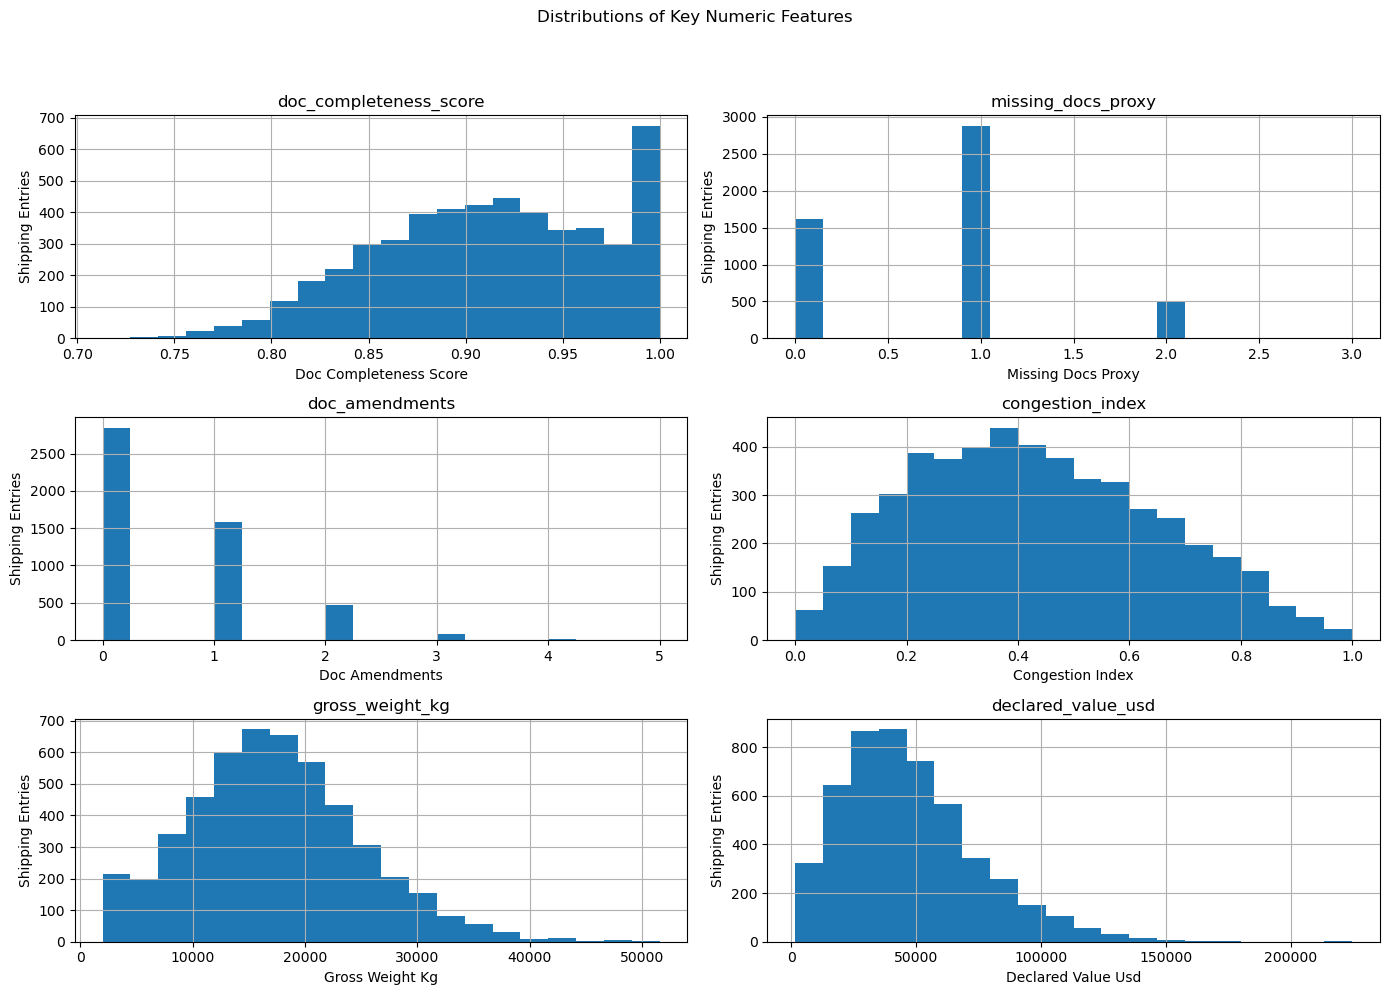

In [6]:
# Histogram plots
axes_subplots = df[numeric_cols].hist(bins=20, figsize=(14, 10)) # Now `axes_subplots` will be the array of Axes
fig = plt.gcf() # Get the current figure object
plt.suptitle("Distributions of Key Numeric Features", y=1.02) # Adjust title position

# Flatten axes array for easy iteration
axes_flattened = axes_subplots.flatten() # Use the correct variable name

# Label each subplot
for i, col in enumerate(numeric_cols):
    axes_flattened[i].set_xlabel(col.replace('_', ' ').title()) # Clean up column names for labels
    axes_flattened[i].set_ylabel("Shipping Entries")

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

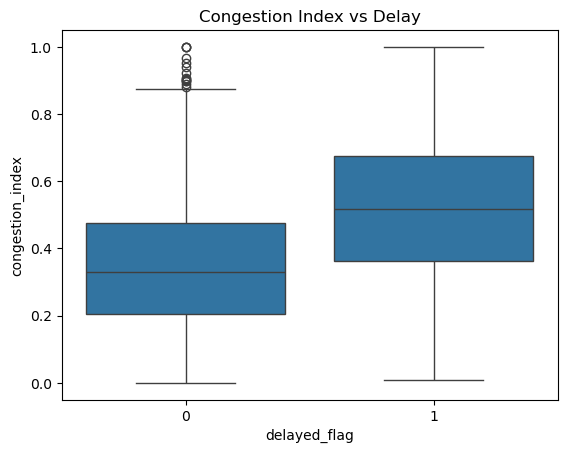

In [7]:
# Relationship between congestion and delay
sns.boxplot(x="delayed_flag", y="congestion_index", data=df)
plt.title("Congestion Index vs Delay")
plt.show()

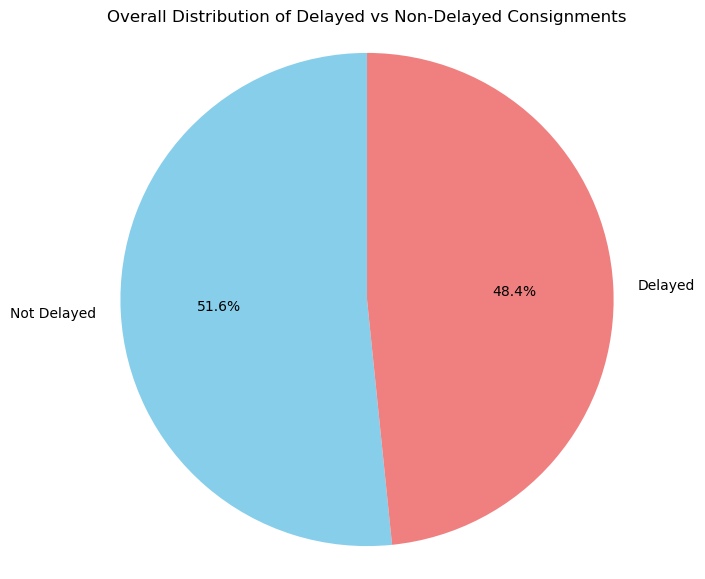

In [8]:
# Overall Delay Distribution for All Shipments
overall_delay_counts = df['delayed_flag'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    overall_delay_counts,
    labels=overall_delay_counts.index.map({0: 'Not Delayed', 1: 'Delayed'}),
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral']
)
plt.title('Overall Distribution of Delayed vs Non-Delayed Consignments')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

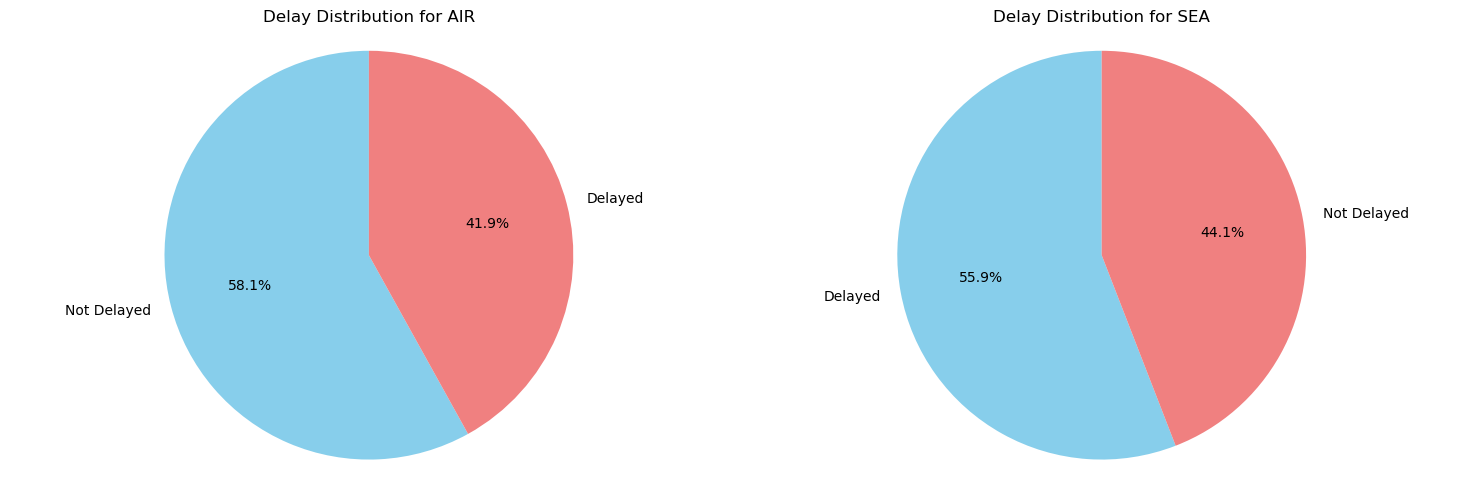

In [9]:
# Shipment mode vs delay as pie charts
fig, axes = plt.subplots(1, df['shipment_mode'].nunique(), figsize=(15, 5))
axes = axes.flatten()

for i, mode in enumerate(df['shipment_mode'].unique()):
    mode_data = df[df['shipment_mode'] == mode]['delayed_flag'].value_counts()
    if not mode_data.empty:
        axes[i].pie(mode_data, labels=mode_data.index.map({0: 'Not Delayed', 1: 'Delayed'}), autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
        axes[i].set_title(f'Delay Distribution for {mode}')
        axes[i].axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    else:
        axes[i].set_title(f'No data for {mode}')
        axes[i].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

# **DATA PREPARATION**

**Key Actions**

* Features grouped into:

  *  Numeric

  *  Categorical

  *  Binary
* Split data into training and test datasets and stratify split to preserve class balance
* Pipelines used to prevent data leakage

In [13]:
# Feature grouping
# Binary feature
binary_features = ["is_weekend_created"]

# Continuous numeric features
numeric_features = [
    "gross_weight_kg",
    "declared_value_usd",
    "doc_completeness_score",
    "missing_docs_proxy",
    "doc_amendments",
    "congestion_index"
]

# Categorical features
categorical_features = [
    "shipment_mode",
    "commodity",
    "hs_code",
    "origin_country",
    "destination_country",
    "exporter_profile"
]

# Combine all predictors
FEATURES = numeric_features + categorical_features + binary_features
TARGET = "delayed_flag"

X = df[FEATURES]
y = df[TARGET]

# -------------------------
# Train–test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserves class balance
)

# -------------------------
# Preprocessing pipeline
# -------------------------
# - Scale numeric features
# - Pass binary feature unchanged
# - One-hot encode categorical features

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)
preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['gross_weight_kg', 'declared_value_usd',
                                  'doc_completeness_score',
                                  'missing_docs_proxy', 'doc_amendments',
                                  'congestion_index']),
                                ('bin', 'passthrough', ['is_weekend_created']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['shipment_mode', 'commodity', 'hs_code',
                                  'origin_country', 'destination_country',
                                  'exporter_profile'])])


# **MODELING**

Models chosen to be evaluated based on data strucutre and type

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost
5. LightGBM

**Modeling Approach**

* Hyperparameter tuning via GridSearch and Stratified 5-fold cross-validation

* Class imbalance handled using class weights (where applicable)

* Model scores generated to view performance

In [14]:
# Model definitions and grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "params": {"model__C": [0.1, 1, 10]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {"model__max_depth": [None, 5, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"model__n_estimators": [100, 200]}
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(class_weight="balanced", random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1]
        }
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_results = {}
baseline_roc = {}
baseline_best_estimators = {}

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning,
)

# Training and evaluation loop

for name, cfg in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", cfg["model"])
    ])

    grid = GridSearchCV(
        pipe,
        cfg["params"],
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    baseline_best_estimators[name] = best_model
    best_model = grid.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Store metrics
    baseline_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

    # ROC data
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    baseline_roc[name] = (fpr, tpr)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

baseline_results_df = pd.DataFrame(baseline_results).T.sort_values("F1", ascending=False)
baseline_results_df


Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       516
           1       0.81      0.80      0.81       484

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.84      0.80       516
           1       0.81      0.70      0.75       484

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000


Random Forest
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       516
           1       0.80      0.77      0.79       484

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.813,0.808732,0.803719,0.806218,0.897683
XGBoost,0.806,0.812500,0.778926,0.795359,0.889891
LightGBM,0.795,0.793684,0.778926,0.786236,0.888029
Random Forest,0.797,0.803456,0.768595,0.785639,0.879497
Decision Tree,0.777,0.809976,0.704545,0.753591,0.853436


# **MODEL EVALUATION**

**Evaluation Focus**

* Compare all models visually and numerically

* Select best model based on classification metrics

* Examine error trade-offs using confusion matrix

* Assess discrimination using ROC curves

* Explain predictions via feature importance

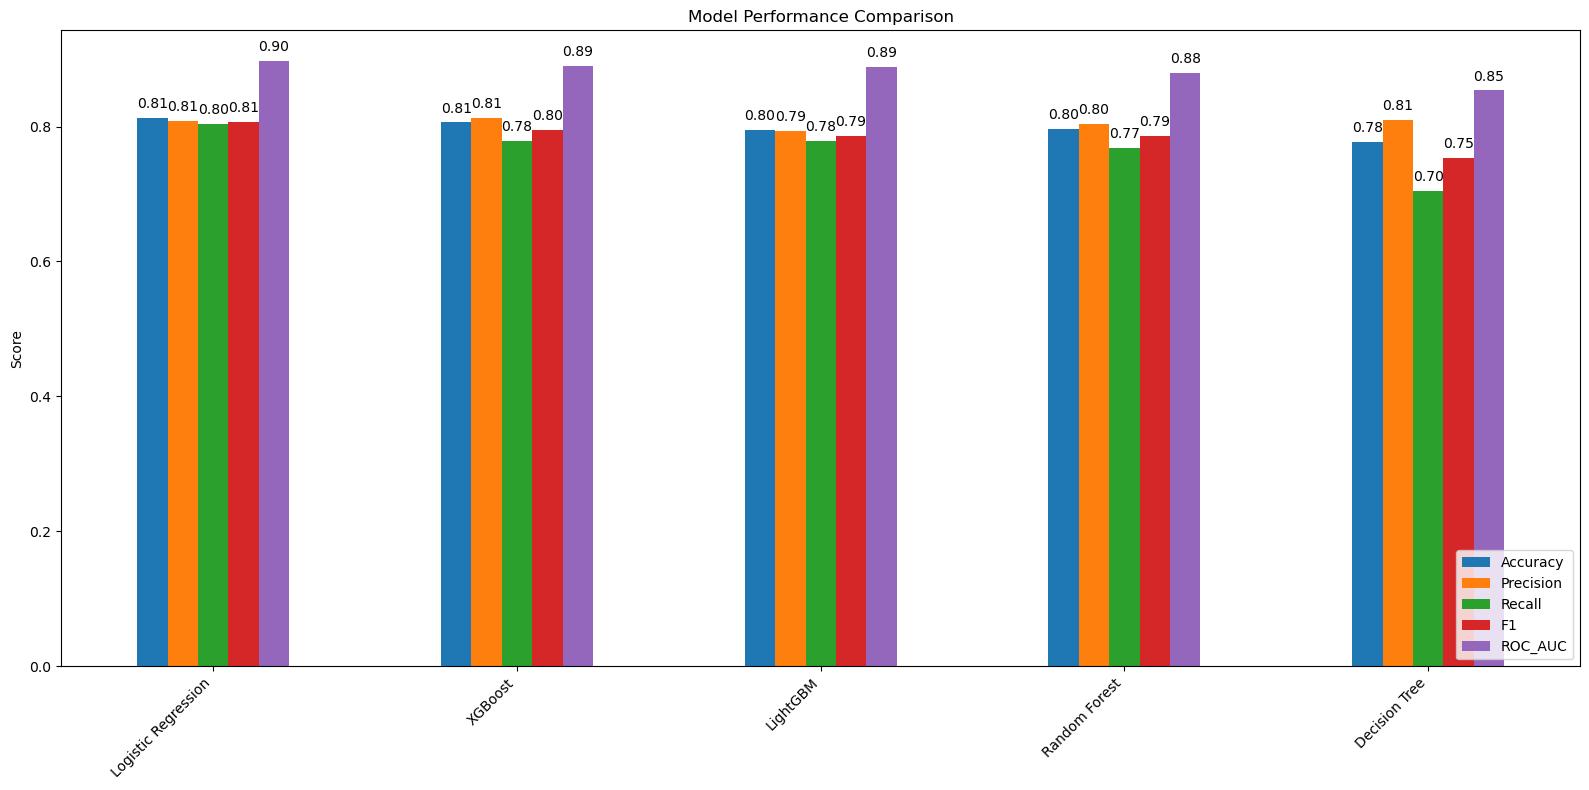

In [15]:
# -------------------------
# Model comparison bar chart
# -------------------------
ax = baseline_results_df.plot(kind="bar", figsize=(16, 8)) # Increased figure width for more space
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")

# Add values on top of each bar with padding
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=5) # Added padding to lift labels slightly

plt.legend(loc='lower right') # Move legend to the bottom right corner
plt.tight_layout()
plt.show()

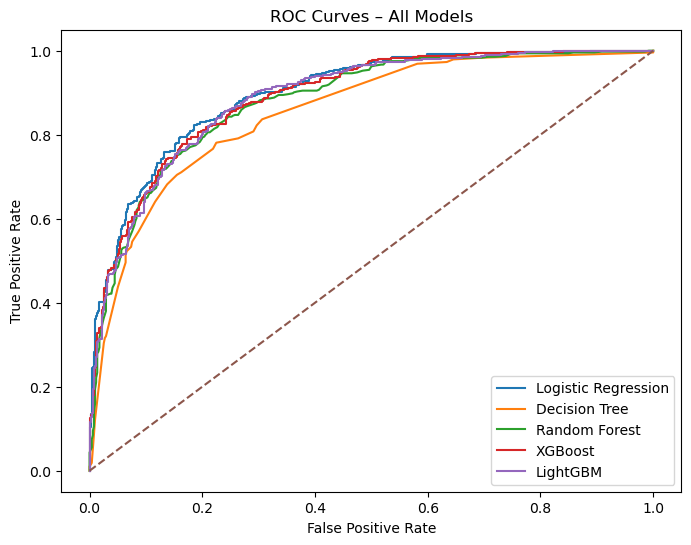


ROC-AUC Values for Each Model:
                      ROC_AUC
Logistic Regression  0.897683
XGBoost              0.889891
LightGBM             0.888029
Random Forest        0.879497
Decision Tree        0.853436


In [16]:
# -------------------------
# ROC curves for all models
# -------------------------
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in baseline_roc.items():
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves – All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Display ROC-AUC values in a table
print("\nROC-AUC Values for Each Model:")
print(baseline_results_df[['ROC_AUC']])

# **BEST MODEL DIAGNOSTICS**

The best model based on ROC_AUC is: Logistic Regression with an ROC_AUC score of 0.90
F1-score was chosen as the primary metric due to potential class imbalance and the need for a balanced measure of precision and recall.


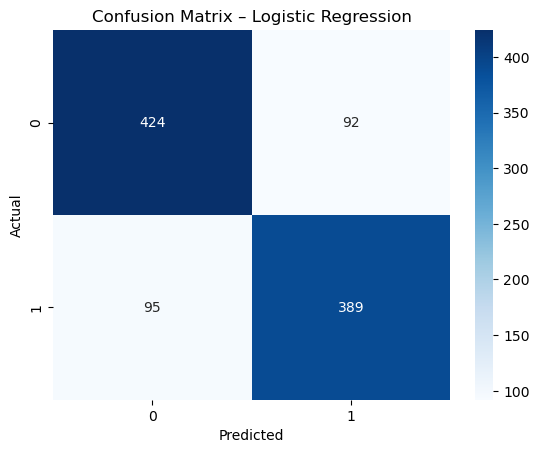

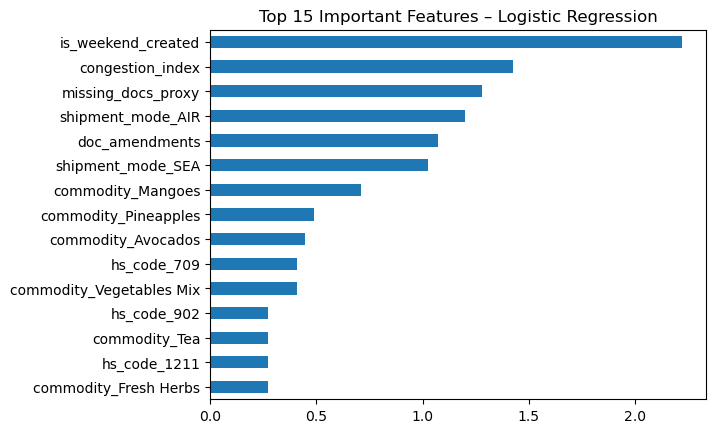

In [17]:
# Identify best model by classification matrics
best_model_name = baseline_results_df.index[0]
best_ROC_AUC_score = baseline_results_df.loc[best_model_name, 'ROC_AUC']

print(f"The best model based on ROC_AUC is: {best_model_name} with an ROC_AUC score of {best_ROC_AUC_score:.2f}")
print("F1-score was chosen as the primary metric due to potential class imbalance and the need for a balanced measure of precision and recall.")

best_pipeline = GridSearchCV(
    Pipeline([
        ("preprocessor", preprocessor),
        ("model", models[best_model_name]["model"])
    ]),
    models[best_model_name]["params"],
    scoring="f1",
    cv=cv
).fit(X_train, y_train).best_estimator_

# Confusion matrix
cm = confusion_matrix(y_test, best_pipeline.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Feature importance / coefficients

model_step = best_pipeline.named_steps["model"]

feature_names = (
    numeric_features +
    binary_features +
    list(
        best_pipeline.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

# Tree models vs linear model handling
if hasattr(model_step, "feature_importances_"):
    importance = model_step.feature_importances_
elif hasattr(model_step, "coef_"):
    importance = np.abs(model_step.coef_[0])
else:
    importance = None

if importance is not None:
    fi = pd.Series(importance, index=feature_names).sort_values(ascending=False).head(15)
    fi.plot(kind="barh")
    plt.title(f"Top 15 Important Features – {best_model_name}")
    plt.gca().invert_yaxis()
    plt.show()

# MODEL ITERATION: RIDGE & LASSO LOGISTIC REGRESSION (POST-BASELINE)
### Applied only after confirming baseline Logistic Regression is the best-performing model to optimize and select features.

In [21]:
logistic_variants = {
    "Logistic (Unregularized)": LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Ridge (L2)": LogisticRegression(
        penalty="l2",
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Lasso (L1)": LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=2000,
        class_weight="balanced"
    )
}

regularized_results = {}

for name, model in logistic_variants.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    if name == "Logistic (Unregularized)":
        param_grid = {}
    else:
        param_grid = {"model__C": [0.01, 0.1, 1, 10]}

    grid = GridSearchCV(
        pipe,
        param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    regularized_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

regularized_results_df = pd.DataFrame(regularized_results).T
regularized_results_df

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic (Unregularized),0.813,0.808732,0.803719,0.806218,0.897599
Logistic Ridge (L2),0.813,0.808732,0.803719,0.806218,0.897683
Logistic Lasso (L1),0.813,0.808732,0.803719,0.806218,0.897719


In [23]:
# Logistic variants including Elastic Net
logistic_variants = {
    "Logistic (Unregularized)": LogisticRegression(
        penalty=None,
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Ridge (L2)": LogisticRegression(
        penalty="l2",
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Lasso (L1)": LogisticRegression(
        penalty="l1",
        solver="saga", # Corrected solver to a valid one for L1 penalty
        max_iter=2000,
        class_weight="balanced"
    ),
    "Logistic ElasticNet": LogisticRegression(
        penalty="elasticnet",
        solver="saga", # Corrected solver to a valid one for ElasticNet penalty
        max_iter=2000,
        class_weight="balanced"
    )
}

regularized_results = {}

for name, model in logistic_variants.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Hyperparameter grid
    if name == "Logistic ElasticNet":
        param_grid = {
            "model__C": [0.01, 0.1, 1, 10],
            "model__l1_ratio": [0.1, 0.5, 0.9]  # Elastic Net mixing ratio
        }
    elif name == "Logistic (Unregularized)":
        param_grid = {}
    else:
        param_grid = {
            "model__C": [0.01, 0.1, 1, 10]
        }

    grid = GridSearchCV(
        pipe,
        param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    regularized_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame
regularized_results_df = pd.DataFrame(regularized_results).T

# Highlight best metric per column
highlight_best = regularized_results_df.style.highlight_max(axis=0, color="lightgreen")
highlight_best

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic (Unregularized),0.813000,0.808732,0.803719,0.806218,0.897599
Logistic Ridge (L2),0.813000,0.808732,0.803719,0.806218,0.897683
Logistic Lasso (L1),0.813000,0.808732,0.803719,0.806218,0.897719
Logistic ElasticNet,0.813000,0.808732,0.803719,0.806218,0.897755


Best model based on ROC_AUC score: Logistic ElasticNet
                     feature  coefficient
6         is_weekend_created     2.235069
5           congestion_index     1.424565
3         missing_docs_proxy     1.288822
7          shipment_mode_AIR    -1.159086
4             doc_amendments     1.073068
8          shipment_mode_SEA     0.885117
13         commodity_Mangoes     0.592711
14      commodity_Pineapples    -0.414302
9         commodity_Avocados    -0.414177
19               hs_code_709    -0.359989
16  commodity_Vegetables Mix    -0.359989
25         origin_country_RW     0.270742
28    destination_country_BE     0.265968
21               hs_code_902    -0.225041
15             commodity_Tea    -0.225041


/var/folders/nn/6v8sy6r911d4ly_fvkqm3r6c0000gn/T/ipykernel_35104/3816035698.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


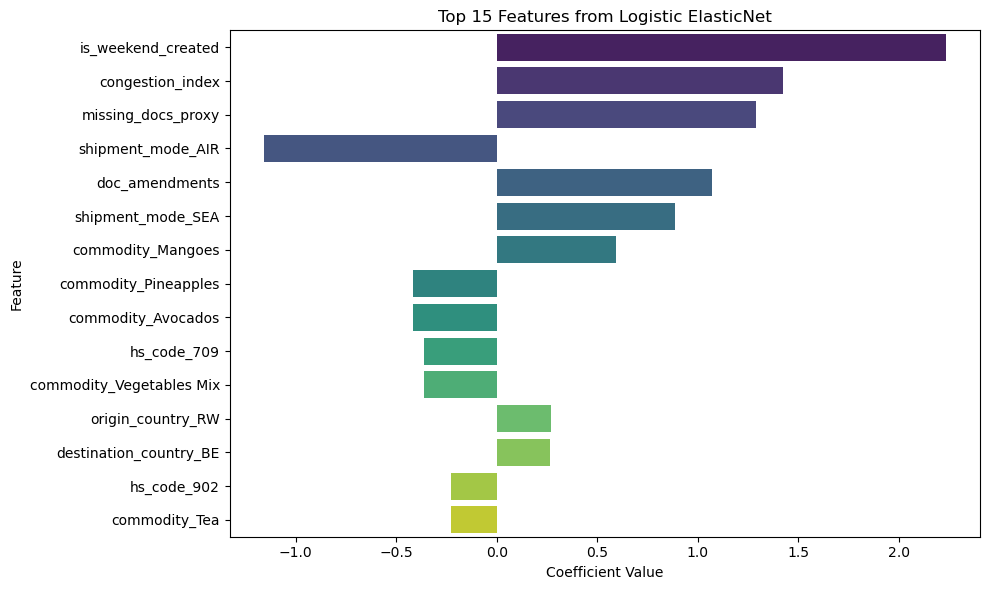

In [24]:

# FINAL MODEL INTERPRETATION (BEST LOGISTIC MODEL)

# Pick the best model based on ROC_AUC score
best_model_name = regularized_results_df["ROC_AUC"].idxmax()
print(f"Best model based on ROC_AUC score: {best_model_name}")

# Refit the best model on the full training data
best_model = GridSearchCV(
    Pipeline([
        ("preprocessor", preprocessor),
        ("model", logistic_variants[best_model_name])
    ]),
    {"model__C": [0.01, 0.1, 1, 10]} if best_model_name != "Logistic ElasticNet" else
    {"model__C": [0.01, 0.1, 1, 10], "model__l1_ratio": [0.1, 0.5, 0.9]},
    scoring="f1",
    cv=cv
).fit(X_train, y_train).best_estimator_

# Extract encoded feature names
encoded_feature_names = (
    numeric_features +
    binary_features +
    list(
        best_model.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

# Get model coefficients
coeffs = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": encoded_feature_names,
    "coefficient": coeffs
})

# Keep only non-zero coefficients and sort by absolute value
selected_features = coef_df[coef_df["coefficient"] != 0]
selected_features = selected_features.reindex(
    selected_features.coefficient.abs().sort_values(ascending=False).index
)

# Display top 15 features
print(selected_features.head(15))

# Visualize top features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=selected_features.head(15),
    x="coefficient",
    y="feature",
    palette="viridis"
)
plt.title(f"Top 15 Features from {best_model_name}")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/var/folders/nn/6v8sy6r911d4ly_fvkqm3r6c0000gn/T/ipykernel_35104/927412945.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


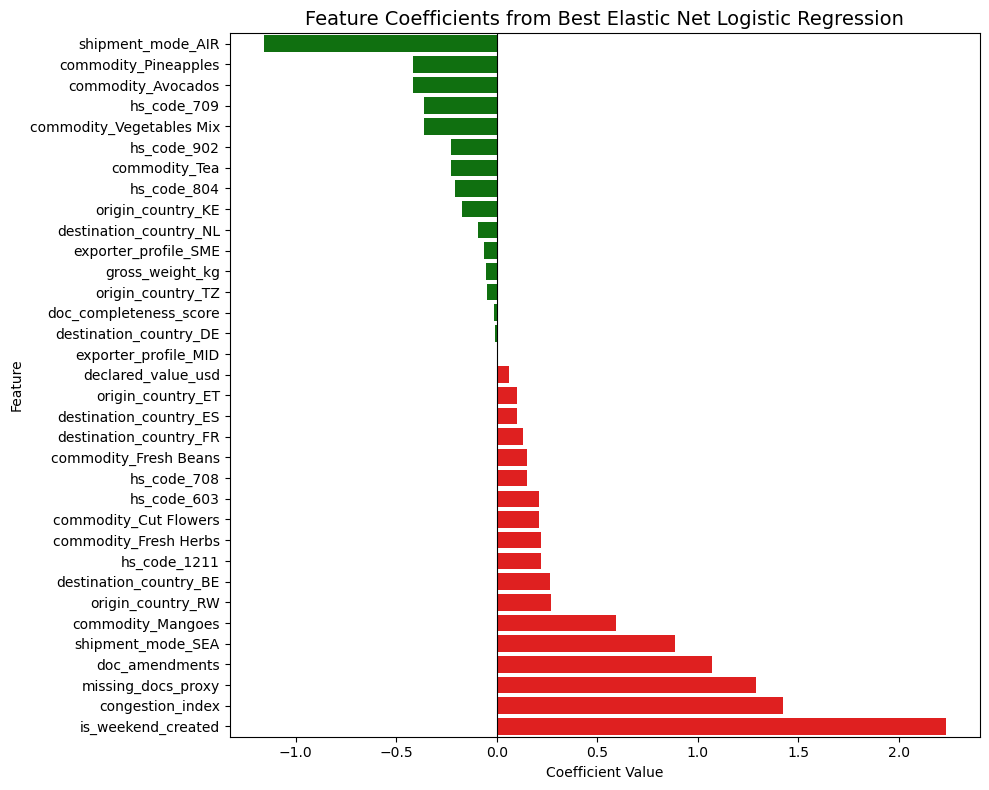

In [25]:

# FEATURE IMPORTANCE VISUALIZATION

# Sort coefficients for visualization
selected_features_sorted = selected_features.sort_values("coefficient", ascending=True).copy()

# Create a color column: red for causes delay, green for does not cause delay
selected_features_sorted["color"] = selected_features_sorted["coefficient"].apply(lambda x: "red" if x > 0 else "green")

plt.figure(figsize=(10, 8))

# Horizontal bar plot
sns.barplot(
    x="coefficient",
    y="feature",
    data=selected_features_sorted,
    palette=selected_features_sorted["color"].to_list()  # Pass a list of colors
)

plt.title("Feature Coefficients from Best Elastic Net Logistic Regression", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="black", linewidth=0.8)  # Line at zero for reference
plt.tight_layout()
plt.show()


# **MODEL RE-EVALUATION BASED ON SELECTED FEATURES**

In [26]:
# Use only selected features from best logistic model
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning,
)

selected_feature_names = selected_features["feature"].tolist()

# Transform X_train and X_test to keep only selected features
# If using ColumnTransformer, get transformed arrays
X_train_selected = best_model.named_steps["preprocessor"].transform(X_train)
X_test_selected = best_model.named_steps["preprocessor"].transform(X_test)

# Only keep the columns corresponding to selected features
# Assuming order matches encoded_feature_names
selected_indices = [encoded_feature_names.index(f) for f in selected_feature_names]

if hasattr(X_train_selected, "iloc"):
    X_train_selected = X_train_selected.iloc[:, selected_indices]
    X_test_selected = X_test_selected.iloc[:, selected_indices]
else:
    X_train_selected = X_train_selected[:, selected_indices]
    X_test_selected = X_test_selected[:, selected_indices]


tree_models = {
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

tree_results = {}

for name, model in tree_models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_selected)[:, 1]
    else:
        # For models that do not have predict_proba
        y_prob = y_pred

    tree_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame
tree_results_df = pd.DataFrame(tree_results).T
tree_results_df


/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:44:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1935, number of negative: 2065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483750 -> initscore=-0.065023
[LightGBM] [Info] Start training from score -0.065023


,Accuracy,Precision,Recall,F1,ROC_AUC
Decision Tree,0.739,0.736730,0.716942,0.726702,0.738316
Random Forest,0.792,0.796137,0.766529,0.781053,0.876896
XGBoost,0.784,0.780335,0.770661,0.775468,0.872101
LightGBM,0.808,0.811966,0.785124,0.798319,0.887681


# **Observations**

The table shows the top features selected by the Elastic Net logistic regression model along with their coefficients:

**Key patterns:**

1. Strongest positive predictors:

- is_weekend_created and congestion_index are the most influential factors increasing risk.

- Operational timing and congestion are critical factors.

2. Shipment mode effects:

- AIR reduces risk, while SEA increases it — indicating mode choice is important.

3. Documentation effects:

- Missing or amended documents (missing_docs_proxy, doc_amendments) increase likelihood of the target event.

4. Commodity and HS code effects:

- Some commodities (Mangoes, Fresh Herbs) slightly increase risk, while others (Pineapples, Avocados, Tea) slightly reduce it.

- Certain HS codes also contribute positively or negatively, reflecting underlying regulatory or handling patterns.

**Discussion on Model Performance**

- Logistic regression with Elastic Net regularization outperformed all other models, including tree-based models like Decision Tree, Random Forest, XGBoost, and LightGBM.

- Elastic Net combines L1 and L2 penalties, which: Selects important features (like Lasso) and Stabilizes coefficients (like Ridge) for correlated features.




- This explains why logistic regression with Elastic Net could achieve better generalization than the more flexible tree-based models on this dataset.

- Using features selected by Elastic Net in tree-based models may improve their performance, but they did not surpass the logistic model in our evaluation — suggesting that the linear relationships captured by logistic regression are dominant, and unnecessary complexity from tree ensembles does not add predictive power here.

# **Conclusions**

**1.  Best Model:**

- Elastic Net-enhanced logistic regression.

- Achieves strong F1 score, ROC-AUC, and interpretable feature selection.

**2. Feature Insights:**

- Weekend shipments, congestion, shipment mode, and documentation issues are the most critical predictors.

- Commodity type and HS code have moderate effects.

**3. Operational Implications:**

- Interventions could focus on high-risk shipments flagged by the model.

- Monitoring weekend operations, congestion points, and document completeness could reduce risk.

**4. Interpretability Advantage:**

- Logistic regression coefficients allow direct interpretation of feature effects, unlike black-box models (XGBoost/LightGBM), which is valuable for business decisions.